# Supernova SNR (aka Detection Rate) metric

This metric corresponds to the detection rate of a faint [(x1,color) = (-2.0,0.2)] supernovae. It is estimated by comparing,at a given time MJDcurcur,the Signal-to-Noise Ratio (SNR) of a supernovae with T0=MJDcurcur -10 to the SNR one would have with a regular cadence SNRrefref(mean value of the corresponding period of study) : if SNR ≥≥ SNRrefref, the supernovae can be detected.This metric is sensitive to internight gap variations.

Input parameters

- band
- z : redshift value for the study
- Li_files : list of npy files with light curves
- mag_to_flux : list of npy files with mag to flux conversion
- config_fake : dict of parameters to simulate "fake" observations (to estimate SNRrefref)



## Imports

In [1]:
import lsst.sims.maf.metricBundles as metricBundles
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.db as db
import lsst.sims.maf.utils as utils
import sqlite3
import numpy as np
from sn_metrics.sn_snr_metric import SNSNRMetric
from sn_tools.sn_cadence_tools import ReferenceData
import sn_plotters.sn_snrPlotters as sn_plot

/home/philippe/.local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## DB file choice

In [2]:
dbName = 'kraken_2026.db'
dbFile = '/home/philippe/LSST/DB_Files/{}'.format(dbName)
opsimdb = db.OpsimDatabase(dbFile)
version = opsimdb.opsimVersion
#propinfo, proptags = opsimdb.fetchPropInfo()
#print('proptags and propinfo', proptags, propinfo)
runLength = opsimdb.fetchRunLength()

## Parameter choice (field type, bands, z, ...)

In [19]:
fieldtype='WFD' #fieldtype: DD or WFD

propinfo, proptags = opsimdb.fetchPropInfo()
print('proptags and propinfo', proptags, propinfo)

sqlconstraint = opsimdb.createSQLWhere(fieldtype, proptags)

if fieldtype == 'DD':
    coadd = True
    fracmin = 0.05
    fracmax = 1.0
if fieldtype == 'WFD':
    coadd = False
    fracmin = 0.05
    fracmax = 1.0
    
Li_files = ['../reference_files/Li_SNCosmo_-2.0_0.2.npy']
mag_to_flux_files = ['../reference_files/Mag_to_Flux_SNCosmo.npy']
names_ref = ['SNCosmo']
fake_file = '../input/Fake_cadence.yaml'

bands = 'r'
z=0.3
nside = 64

proptags and propinfo {'WFD': [3], 'DD': [5], 'NES': [4]} {1: 'GalacticPlane', 2: 'SouthCelestialPole', 3: 'WideFastDeep', 4: 'NorthEclipticSpur', 5: 'DeepDrillingCosmology1'}


## Define slicer

In [20]:
slicer = slicers.HealpixSlicer(nside=nside)

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


## Make MAF bundle of metrics

In [21]:
bundles=[]
names = []
for band in bands:
    sql_i = sqlconstraint+' AND '
    sql_i += 'filter = "%s"' % (band)

    lim_sn = ReferenceData(Li_files, mag_to_flux_files, band, z)

    metric = SNSNRMetric(lim_sn=lim_sn, names_ref=names_ref,fake_file=fake_file, coadd=coadd, z=z,season=[2])
    bundles.append(metricBundles.MetricBundle(metric, slicer, sql_i))
    names.append(band)

bdict = dict(zip(names, bundles)) #bundle dict

## Run the bundle of metrics

In [22]:
outDir = '{}_Cadence'.format(dbName)
resultsDb = db.ResultsDb(outDir=outDir)
mbg = metricBundles.MetricBundleGroup(bdict, opsimdb,
                                          outDir=outDir, resultsDb=resultsDb)

mbg.runAll()

Querying database SummaryAllProps with constraint proposalId = 3 AND filter = "r" for columns ['filter', 'numExposures', 'visitTime', 'observationStartMJD', 'night', 'visitExposureTime', 'observationId', 'fiveSigmaDepth', 'fieldDec', 'fieldRA']
Found 460469 visits
Running:  ['r']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


## Display the results

/home/philippe/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:734: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


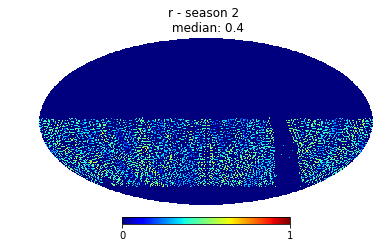

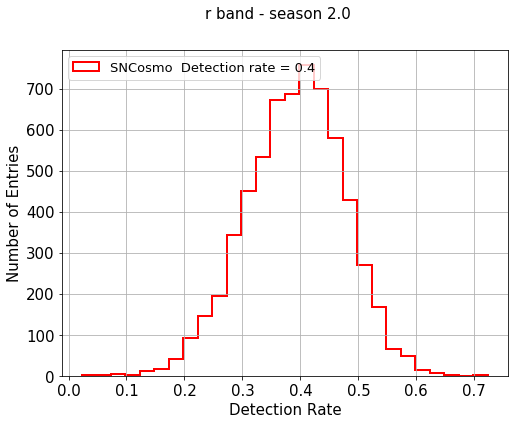

In [25]:
%matplotlib inline
for band, val in bdict.items():
    metValues = val.metricValues[~val.metricValues.mask]
    res = None
    for vals in metValues:
        if vals is not None:
            if res is None:
                res = vals
            else:
                res = np.concatenate((res, vals))
    res = np.unique(res)

    sn_plot.detecFracPlot(res,nside, names_ref)

    sn_plot.detecFracHist(res, names_ref)